In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import numpy as np
import pandas as pd
import time
import datetime
import seaborn as sns
from nltk import flatten
%matplotlib notebook

In [106]:
site = 'Angachilla' #'Miraflores' #'PUEBosque' #'Angachilla'
n_classes = 10

In [107]:
path_report = '../report/predictions/' + site + '/'
csv = [f for f in sorted(os.listdir(path_report)) if f.startswith('MON') and f.endswith('.csv')]

In [108]:
dates=[]
for d in csv:
    dates.append(d.split('_')[1])
dates = sorted(list(set(dates)))


P=[]
for e in dates:
    P_temp = []
    for g in csv:
        if g.split('_')[1] == e:
            P_temp.append(pd.read_csv(path_report + g))
    P.append(P_temp)

In [109]:
TH = pd.read_csv('THRESHOLDS.csv', index_col=0)
#TH['Manual'] = [0.10, 0.90, 0.10, 0.99, 0.10, 0.999, 0.999, 0.999, 0.10, 0.999] 
TH['Manual'] = [0.10, 0.95, 0.20, 0.99, 0.57, 0.99, 0.99, 0.99, 0.17, 0.999] 

TH

,Specie,ROC,PrRe,Manual
0,Agelasticus thilius,0.001286,0.001879,0.100
1,Cistothorus platensis,0.008427,0.037462,0.950
2,Colorhamphus parvirostris,0.000189,0.000660,0.200
3,Elaenia albiceps,0.002482,0.132049,0.990
4,Gallinago paraguaiae,0.010106,0.030668,0.570
5,Glaucidium nana a,0.037583,0.179798,0.990
6,Glaucidium nana b,0.570351,0.589231,0.990
7,Pardirallus sanguinolentus,0.003177,0.041978,0.990
8,Porzana spiloptera kiker,0.000739,0.057961,0.170
9,Porzana spiloptera pw,0.064688,0.388855,0.999


In [110]:
#Call5: Calls in the first 5 min of each hour of the day:
import datetime
def Call5(d, date, Roc_or_PrRe, specie):
    TH_specie = TH.iloc[specie,Roc_or_PrRe]
    duration_file = len(P[0][0])
    prob_value = []
    C5 = []
    presences_date = []
    
    for h in range(24):
        temp_C5 = []
        #temp_prob_value = []
        try:
            for s in range(duration_file):
                day = datetime.date(int(date[0:4]),int(date[4:6]),int(date[6::]))
                mm = s // 60
                ss = s % 60
                time = datetime.time(h, mm, ss)
                index_datetime = datetime.datetime.combine(day, time)
                #temp_prob_value.append(P[d][h].iloc[s, specie])
                if P[d][h].iloc[s, specie] >= TH_specie:
                    temp_C5.append(1)
                    presences_date.append(index_datetime)
                    prob_value.append(P[d][h].iloc[s, specie])
                else:
                    temp_C5.append(0)
            C5.append(sum(temp_C5))
            #prob_value_hr.append(temp_prob_value)
        except:
            print('No audio from: ' + date)
            C5.append(np.NaN)
            continue
    #print(date)
    #print(C5, '\n')
    #print(np.array(presences_date), '\n')
    return C5, presences_date, prob_value

### Store Call5 & Presences 

In [111]:
%%time
for n in range(8,9):
    print(TH.iloc[n,0])
    
    #Call5 per class:
    C5_matrix = np.zeros([24, len(dates)])
    presences = []
    prob = []
    for d, date in enumerate(dates):
        C5_matrix[:,d], _presences, _prob = Call5(d = d, 
                                           date = date,  
                                           Roc_or_PrRe = 3, # Roc:1 PrRe:2 Manual:3
                                           specie = n)
        presences.append(_presences)
        prob.append(_prob)
    print('ok C5_matrix')   
    #Repair C5_matrix with lost days:
    if site == 'Miraflores':
        # insertar en indice 87 dos columnas (13 y 14 de enero)
        C5_fixed = C5_matrix
        C5_fixed = np.insert(C5_fixed, [87], [0, 0], axis=1)
        # insertar en indice 239, 18 columnas (del 14 de junio al 1 de julio, ambos inclusive)
        a = np.empty((24,18))
        a[:] = 0
        C5_fixed = np.insert(C5_fixed, [239], a, axis=1)
        print('Fixed Miraflores')
    elif site == 'PUEBosque':
        # insertar en indice 156, 13 columnas (del 23 de marzo al 4 de abril, ambos inclusive)
        a = np.empty((24,13))
        a[:] = 0
        C5_fixed = C5_matrix
        C5_fixed = np.insert(C5_fixed, [156], a, axis=1)
        # agregar al final, 19 columnas (del 9 al 27 de noviembre, ambos inclusive)
        a = np.empty((24,19))
        a[:] = 0
        C5_fixed = np.concatenate((C5_fixed, a), axis=1)
        print('Fixed PUEBosque')
    elif site == 'Angachilla':
        # insertar en indice 87, 1 columna (14 de enero)
        C5_fixed = C5_matrix
        C5_fixed = np.insert(C5_fixed, [87], [0], axis=1)
        # insertar en indice 141, 11 columnas (del 8 al 18 de marzo, ambos inclusive)
        a = np.empty((24,11))
        a[:] = 0
        C5_fixed = np.insert(C5_fixed, [141], a, axis=1)
        # insertar en indice 167, 1 columna (3 de abril)
        C5_fixed = np.insert(C5_fixed, [167], [0], axis=1)
        # insertar en indice 300, 39 columnas (del 14 de agosto al 21 de septiembre, ambos inclusive)
        a = np.empty((24,39))
        a[:] = 0
        C5_fixed = np.insert(C5_fixed, [300], a, axis=1)
        # agregar al final, 14 columnas (del 14 al 27 de noviembre, ambos inclusive)
        a = np.empty((24,14))
        a[:] = 0
        C5_fixed = np.concatenate((C5_fixed, a), axis=1)
        print('Fixed Angachilla')

    #Store:
    #write binary
    data_store = open('../binarios/'+ site + '/' + TH.iloc[n,0].replace(' ', '_') + '_C5_fixed.pkl', 'wb') 
    pickle.dump(C5_fixed, data_store)
    data_store.close()

    data_store2 = open('../binarios/'+ site + '/' + TH.iloc[n,0].replace(' ', '_') + '_presences.pkl', 'wb') 
    pickle.dump(presences, data_store2)
    data_store2.close()
    
    data_store3 = open('../binarios/'+ site + '/' + TH.iloc[n,0].replace(' ', '_') + '_probabilities.pkl', 'wb') 
    pickle.dump(prob, data_store3)
    data_store3.close()

    print('Store C5_fixed & presences', '\n')

Porzana spiloptera kiker
ok C5_matrix
Fixed Angachilla
Store C5_fixed & presences 

CPU times: user 1min 9s, sys: 371 ms, total: 1min 10s
Wall time: 1min 11s


### Check

In [112]:
path = '../binarios/'
data_store = open(path+'Angachilla'+'/'+'Porzana_spiloptera_kiker_C5_fixed.pkl', 'rb') 
C5_fixed = pickle.load(data_store)
data_store.close()

In [113]:
data_store2 = open(path+'Angachilla'+'/'+'Porzana_spiloptera_kiker_presences.pkl', 'rb') 
presences = pickle.load(data_store2)
data_store2.close()

In [114]:
data_store3 = open(path+'Angachilla'+'/'+'Porzana_spiloptera_kiker_probabilities.pkl', 'rb') 
probabilities = pickle.load(data_store3)
data_store3.close()

In [115]:
presences_flatten = flatten(presences)
probabilities_flatten = flatten(probabilities)

In [116]:
df = pd.DataFrame(list(zip(presences_flatten, probabilities_flatten)),columns =['detection', 'probability'])

<IPython.core.display.Javascript object>


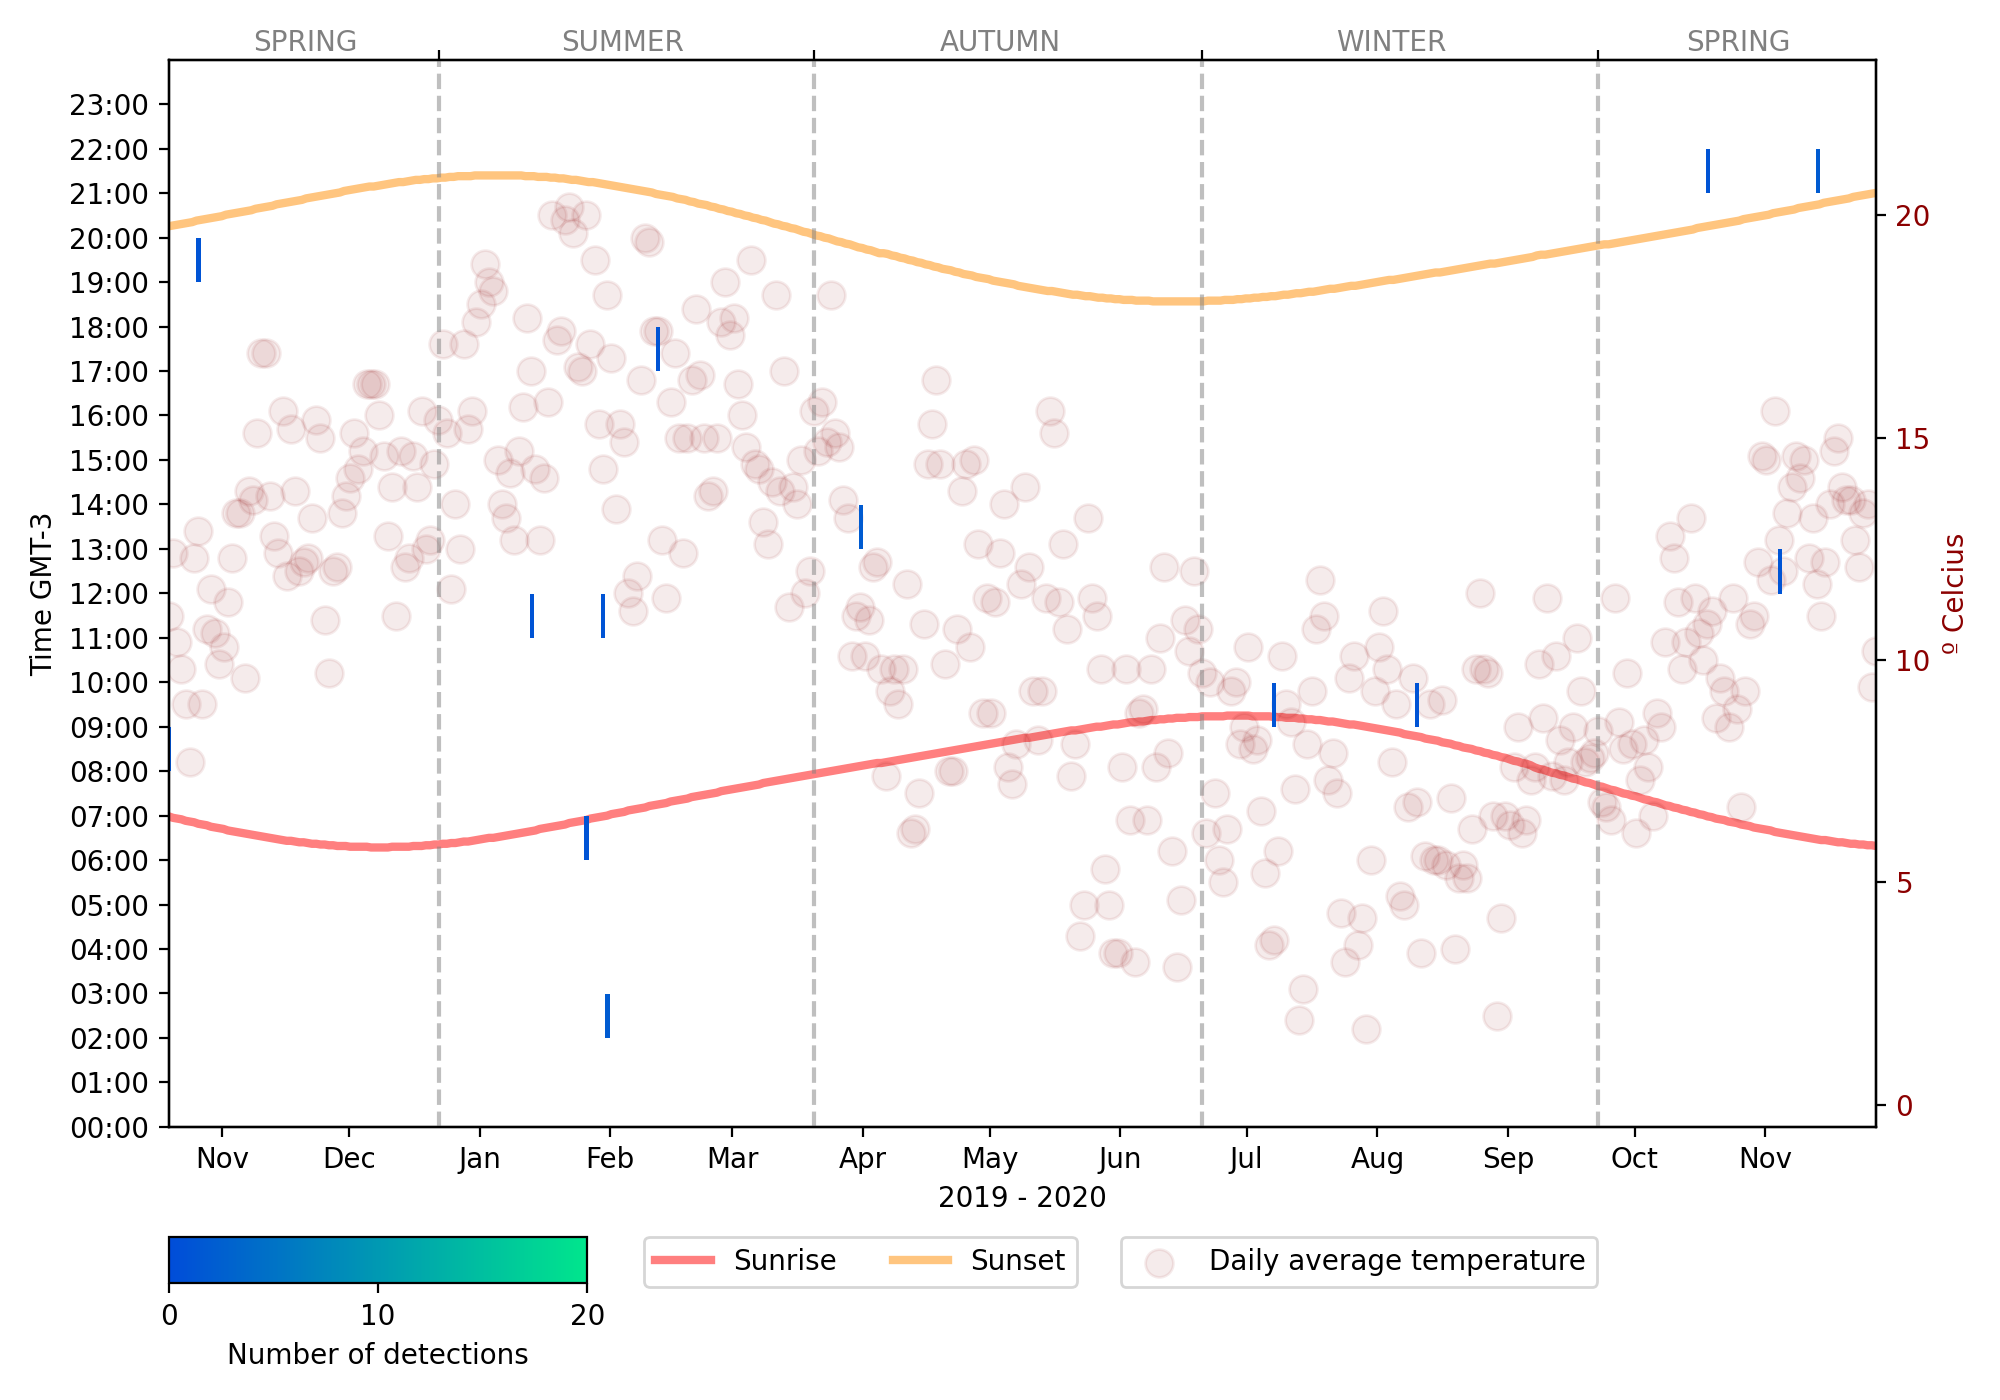

In [117]:
import datetime
horas_sol = pd.read_excel('../DATOS_METEOROLOGICOS/HORAS_LUZ_SOL_temp/2020.xlsx', index_col=0, parse_dates=True)
horas_sol_2019 = pd.read_excel('../DATOS_METEOROLOGICOS/HORAS_LUZ_SOL_temp/2019_.xlsx', index_col=0, parse_dates=True)

#Agregar fecha, porque matplotlib lo requiere:
sunrise_time = []
k=0
for i in range(12):
    for c, t in enumerate(horas_sol.iloc[:,k]):
        if type(t) == datetime.time:
            my_day = datetime.date(2020, i+1, c+1)
            tmp = datetime.datetime.combine(my_day, t)
            sunrise_time.append(tmp)  
    k += 2

sunset_time = []
k=1
for i in range(12):
    for c, t in enumerate(horas_sol.iloc[:,k]):
        if type(t) == datetime.time:
            my_day = datetime.date(2020, i+1, c+1)
            tmp = datetime.datetime.combine(my_day, t)
            sunset_time.append(tmp)  
    k += 2

#Corregir horario de invierno, dejar todo en horario de verano: UTC-3:
sunrise_time[96:250] = [sunrise_time[d] + datetime.timedelta(hours=1) for d in np.arange(96,250)]
sunset_time[96:250] = [sunset_time[d] + datetime.timedelta(hours=1) for d in np.arange(96,250)]

#Agregar fecha, porque matplotlib lo requiere:

sunrise_time_2019 = []
k=0
for i in range(12):
    for c, t in enumerate(horas_sol_2019.iloc[:,k]):
        if type(t) == datetime.time:
            my_day = datetime.date(2019, i+1, c+1)
            tmp = datetime.datetime.combine(my_day, t)
            sunrise_time_2019.append(tmp)  
    k += 2

sunset_time_2019 = []
k=1
for i in range(12):
    for c, t in enumerate(horas_sol_2019.iloc[:,k]):
        if type(t) == datetime.time:
            my_day = datetime.date(2019, i+1, c+1)
            tmp = datetime.datetime.combine(my_day, t)
            sunset_time_2019.append(tmp)  
    k += 2
    
#Corregir horario de invierno, dejar todo en horario de verano: UTC-3:
sunrise_time_2019[97:251] = [sunrise_time_2019[d] + datetime.timedelta(hours=1) for d in np.arange(97,251)]
sunset_time_2019[97:251] = [sunset_time_2019[d] + datetime.timedelta(hours=1) for d in np.arange(97,251)]

sunrise = [*sunrise_time_2019, *sunrise_time]
sunset = [*sunset_time_2019, *sunset_time]
sunrise = pd.to_datetime(sunrise)
sunset = pd.to_datetime(sunset)

from datetime import datetime

sunrise.to_pydatetime()
times = []
for date in sunrise:
    current_time = date.strftime("%H:%M")
    t = datetime.strptime(current_time, '%H:%M').time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    times.append(seconds/86400)

sunset.to_pydatetime()
times2 = []
for date in sunset:
    current_time = date.strftime("%H:%M")
    t = datetime.strptime(current_time, '%H:%M').time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    times2.append(seconds/86400)

temperatura = pd.read_csv('../DATOS_METEOROLOGICOS/HORAS_LUZ_SOL_temp/days_2019_2020.csv')
temperatura_w = pd.read_csv('../DATOS_METEOROLOGICOS/HORAS_LUZ_SOL_temp/weeks_t.csv')
temperatura = temperatura[291:697]

#Create color map:
#https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/
hsv_modified = cm.get_cmap('winter', 256)# create new hsv colormaps in range of 0.3 (green) to 0.7 (blue)
newcmp = ListedColormap(hsv_modified(np.linspace(0.3, 0.9, 256)))# from blue to purple

fig, ax1 = plt.subplots(figsize=(10,7), facecolor='w')

# Data

date_list = sunrise[291:697]
y = times[291:697]
date_list2 = sunset[291:697]
y2 = times2[291:697]

###### Set the locator #####
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
xfmt = mdates.DateFormatter('%b')
yfmt = mdates.DateFormatter('%H:%M')
############################
###### sunlight ############
ax1.plot(date_list, y, label='Sunrise', c='red', zorder=3, alpha=0.5, linewidth=3)
ax1.plot(date_list2, y2, label='Sunset', c='darkorange', zorder=4, alpha=0.5, linewidth=3)
ax1.set_xlabel('2019 - 2020')
ax1.set_ylabel('Time GMT-3')
ax1.set_yticks(np.arange(24)/24)
ax1.set_ylim(0, 1)
ax1.set_xlim(date_list[0], date_list[-1])
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(xfmt)
Y = plt.gca().yaxis
Y.set_major_formatter(yfmt)
############################
###### temperature #########
ax2 = ax1.twinx()
ax2.scatter(date_list, temperatura.iloc[:,1], s=100, alpha=0.08, label='Daily average temperature', 
            c='darkred', zorder=2, vmin=10, vmax=15)
ax2.set_ylabel('º Celcius', c='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
#ax2.set_xlim(0, 1)

###########################
##### heatmap #############

ax3 = ax2.twiny()

data = C5_fixed
masked_data = np.ma.masked_where(data<1, data)
vmin, vmax = (0, 20)

im = ax3.imshow(masked_data, vmin=vmin, vmax=vmax, cmap=newcmp, aspect='auto', 
                zorder=1, interpolation='none',alpha=1)
ax3.invert_yaxis()
ax3.set_xlim(0,405)
ax3.set_xticks(ticks=[64, 153, 245, 339], labels='')
ax3.axvline(64, linestyle='--', color='grey', alpha=0.5)
ax3.axvline(153, linestyle='--', color='grey', alpha=0.5)
ax3.axvline(245, linestyle='--', color='grey', alpha=0.5)
ax3.axvline(339, linestyle='--', color='grey', alpha=0.5)
ax3.text(20,23.7,'SPRING', color='grey')
ax3.text(93,23.7,'SUMMER', color='grey')
ax3.text(183,23.7,'AUTUMN', color='grey')
ax3.text(277,23.7,'WINTER', color='grey')
ax3.text(360,23.7,'SPRING', color='grey')

cbar = fig.colorbar(im, ticks=[vmin, ((vmax-vmin)/2)+vmin, vmax], label = 'Number of detections',
                   fraction=0.038, pad=0.09, orientation='horizontal', aspect=9, anchor=(0, -0.5))

#ax3.axis('off')

###########################


ax1.legend(fontsize=10, ncol=2, bbox_to_anchor=(0.54, -0.09))
ax2.legend(fontsize=10, bbox_to_anchor=(0.845, -0.09))


plt.tight_layout()
plt.savefig('POSP_kiker_Angachilla_0.17.png', format='png', dpi=300)
#plt.savefig('only_meteogram.png', format='png', dpi=300)
plt.show()